<a href="https://colab.research.google.com/github/KlaraDewitte/Machine_Learning_course_UGent_D012554_kaggle/blob/master/Kaggle_eye_blinking_prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#**Load dataset**

The very first step is loading the train- and dataset. 

In the next step we pop the labels in the trainset and the indices in the testset. If we don't do this, this labels and indices will be used as features, which will give us wrong results. We store this in new variables, so we can use these later.

In [0]:
trainset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_train.csv")
testset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_test.csv")

labels = trainset.pop('label')
indices = testset.pop('index')

**Plot the dataset**

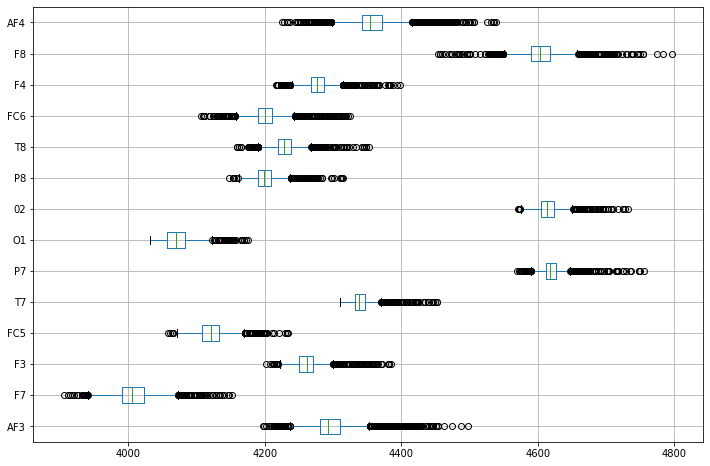

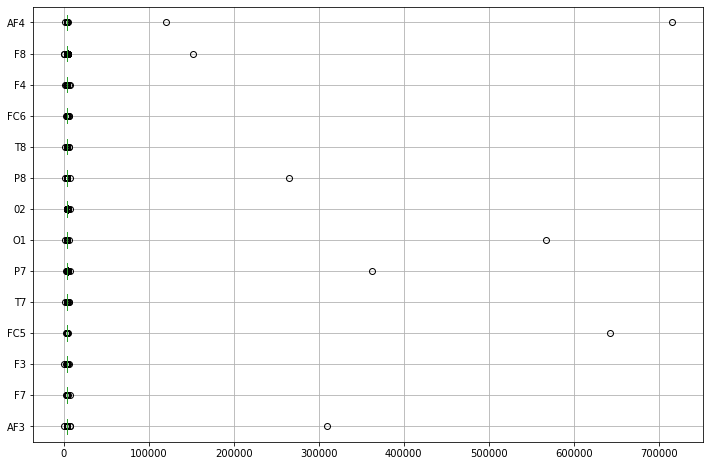

In [0]:
plt.figure(figsize=(12,8))
trainset.boxplot(vert=False)
plt.show()

plt.figure(figsize=(12,8))
testset.boxplot(vert=False)
plt.show()

#**Pre-Processing**

The first preprocessing step in both my models is normalization. This is needed because the features can have different scales, this means they have a different minimum and maximum values. We can see this in the boxplot above. 

**Standard scaler**

First, I tried the Standard Scaler. After standardadization we can see that the features have the properties of a normal distribution with $\mu = 0$ and $\sigma = 1$.

I was not satisfied with this, because I know this scaling method is sensitive to outliers. So I tried antoher scaling method.


In [0]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()
Scaler.fit(trainset)

trainset_scaled = pd.DataFrame(Scaler.transform(trainset))

testset_scaled= pd.DataFrame(Scaler.transform(testset))

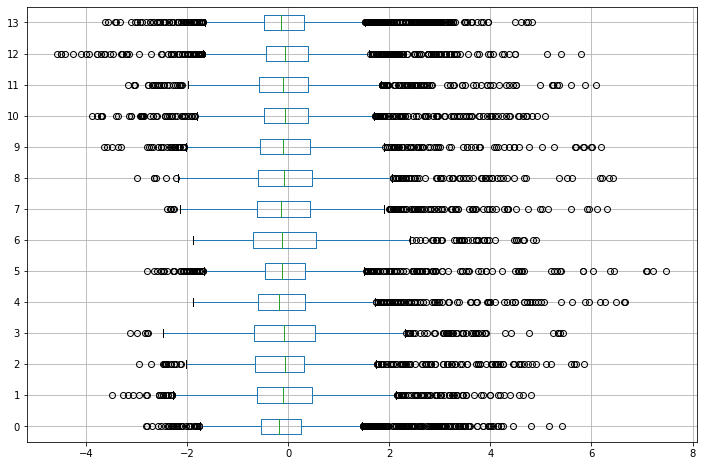

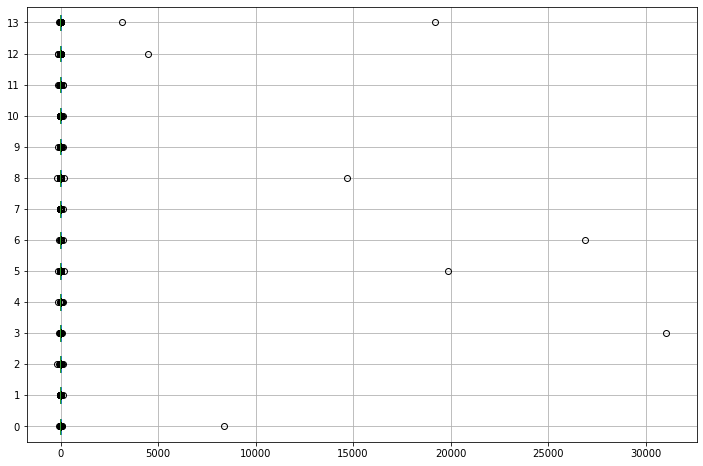

In [0]:
plt.figure(figsize=(12,8))
trainset_scaled.boxplot(vert=False)
plt.show()
plt.figure(figsize=(12,8))
testset_scaled.boxplot(vert=False)
plt.show()


**Robust Scaler**

To fix the problem with the median, I tried the Robust Scaler. This Robust scaler removes the median and scales the data according to the quantile range. This method is better if you have outliers in your dataset. Compared with the standard scaler this gives an even better normalization result (see boxplots).

In [0]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(trainset)
trainset_scaled_robust = pd.DataFrame(scaler.transform(trainset))
testset_scaled_robust = pd.DataFrame(scaler.transform(testset))


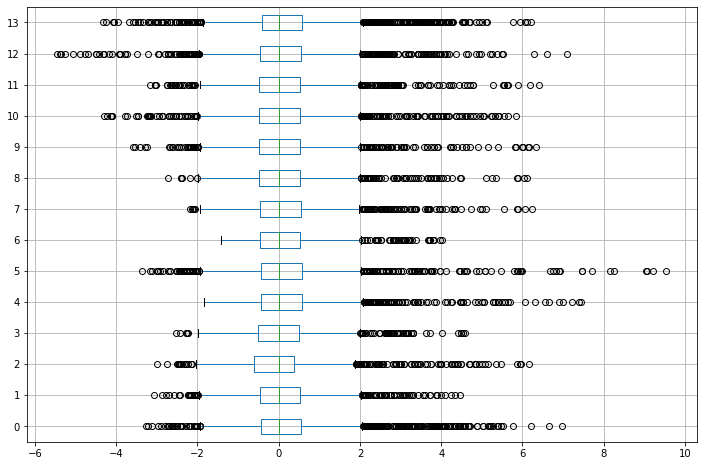

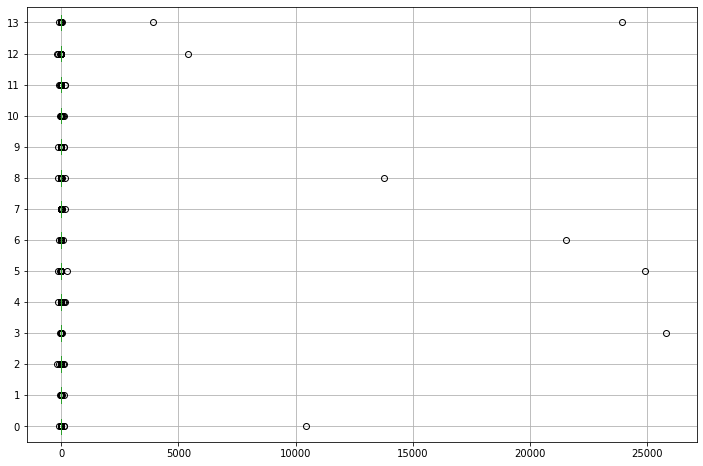

In [0]:
plt.figure(figsize=(12,8))
trainset_scaled_robust.boxplot(vert=False)
plt.show()
plt.figure(figsize=(12,8))
testset_scaled_robust.boxplot(vert=False)
plt.show()

#**Model**

**Random Forrest**

In [0]:
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import cross_val_score

In [0]:
X = trainset_scaled_robust
y = labels

In [0]:
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

params_grid = {'n_estimators':[50,60,70,80], 'max_features':range(1,15)}
model = RandomForestClassifier()

grid_model = GridSearchCV(model, params_grid, cv=10,  n_jobs = -1)
grid_model.fit(X, y)

print(grid_model.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


At first I used the random forest classifier model. This model fits a number of decision tree classifiers on various subsamples of the dataset and uses averaging to improve the predictive accuracy and control overfitting. 

Here we have two hyperparamaters. Via cross-validation we try to find the optimal hyperparameters.

The first hyperparameter (n_estimators) is the number of trees in the forest. The result for this parameter is 70.

The second hyperparameters (max_features) is the number of features to consider when looking for the best split. The optimal number is 4.

**Support Vector Machine**

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import cross_val_score

In [0]:
X_SVM = trainset_scaled_robust
y_SVM = labels

In [0]:
params_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
          'gamma': [0.01, 0.1, 1, 10],
          'kernel':['linear', 'poly', 'rbf', 'sigmoid'] }


grid_clf = GridSearchCV(SVC(class_weight='balanced'), params_grid)
grid_clf.fit(X_SVM, y_SVM)

print(grid_clf.best_estimator_)

SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


As second model I used the support vector machine model. This is a linear classification model and it can be applied on linearly separable two class data sets. In this case eyes opened or eyes closed.

First, we want to find out which kernel function fits the best for our dataset. These functions are linear, polynomeal, radial basis function or sigmoid. 
In this case, the rbf functions fits the best.

There are a few hyperparamaters that can be set for the radial basis function and I used cross-validation to find out which are the best. 

The first one is the hyperparameter C. This controls the balance of the number of data points that contribute to the cost and the size of the margin. The higher this C will be, the higher the contribution of the misclassified data points to the cost will be. The optimal C-value is 10.

The second hyperparameter is gamma. This paramater defines how far the influence of a single training example reaches. Low values means the influence reaches far and high values means the influence reaches close. Here this parameter is optimal at 1.  



#**AUC score and predictions**

In this last part I fitted the model on the trainset and scored the model with the function cross_val_score and with the scoring method roc_auc.  This means the scoring method was the area under the ROC curve.

**Random Forrest**

In [0]:
model=grid_model.best_estimator_

model.fit(X,y)
score_auc = np.mean(cross_val_score(model,X,y,scoring='roc_auc'))
print(score_auc)


0.9193340053069864


In [0]:
predictions = model.predict_proba(testset_scaled_robust)[:,1]
print(predictions)

[0.17142857 0.4        0.04285714 ... 0.85714286 0.81428571 0.18571429]



We see this score is already quite high, 0.9193.



**Support Vector Machine**

In [0]:
clf=SVC(10, gamma=1, kernel='rbf')
clf.fit(X_SVM,y_SVM)
score_auc = np.mean(cross_val_score(clf,X_SVM,y_SVM,cv=10,scoring='roc_auc'))
print(score_auc)

0.9624199847043885


In [0]:
clf=SVC(C=10, gamma=1, kernel='rbf', probability=True)
clf.fit(X_SVM,y_SVM)
predictions_SVM = clf.predict_proba(testset_scaled_robust)[:,1]
print(predictions_SVM)

[4.18702844e-06 8.09979118e-01 7.10993331e-03 ... 9.97118434e-01
 5.00000000e-01 2.40115139e-02]


The same thing was done for the support vector machine model. Here we see the score is even better than with the random forest model.



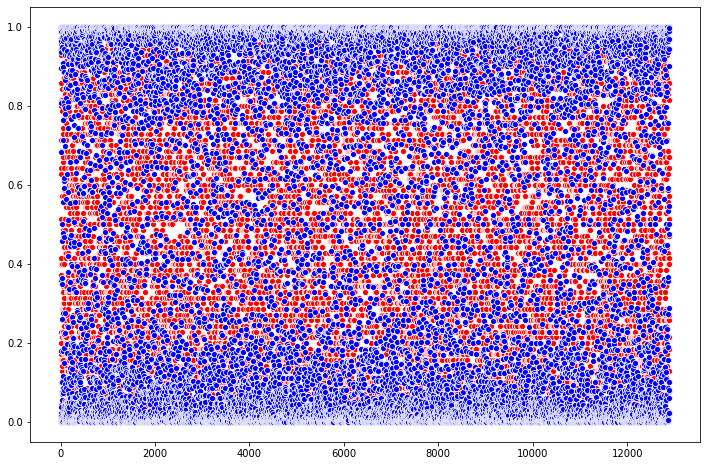

In [0]:

xas = range(0,len(predictions))

plt.figure(figsize=(12,8))

sns.scatterplot(xas,predictions, color="red")
sns.scatterplot(xas,predictions_SVM,color="blue")

plt.show()


Here I plotted the Random Forest Classifier model in red and the SVM model in blue. We can see that the SVM model has more points close to 0 and 1, so this model is more accurate.